<a href="https://colab.research.google.com/github/krishna663-wq/Machine_Learning/blob/main/Bank_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [15]:
data = pd.read_csv('bank_transactions.csv')

In [16]:
data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [17]:
data.shape

(1048567, 9)

In [18]:
data.isnull().sum()

,0
TransactionID,0
CustomerID,0
CustomerDOB,3397
CustGender,1100
CustLocation,151
CustAccountBalance,2369
TransactionDate,0
TransactionTime,0
TransactionAmount (INR),0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [20]:
data.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.570875e+05,1.574335e+03
std,8.464854e+05,5.126185e+04,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.240300e+05,1.610000e+02
50%,1.679218e+04,1.642260e+05,4.590300e+02
75%,5.765736e+04,2.000100e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


In [21]:
from sklearn.preprocessing import LabelEncoder

categorical_features=['TransactionID','CustomerID','CustomerDOB','CustGender','CustLocation','CustAccountBalance','TransactionDate','TransactionTime','TransactionAmount (INR)']

label_encoders={}

for col in categorical_features:

    # Check if the column exists in the DataFrame

    if col in data.columns:

        le=LabelEncoder()

        data[col]=le.fit_transform(data[col])

        label_encoders[col]=le

    else:

        print(f"Column '{col}' not found in the DataFrame. Skipping...")


In [22]:
data = data.drop(columns=['TransactionAmount (INR)'])

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [24]:
# Dimensionality reduction
numerical_features = data.select_dtypes(include=np.number).columns
numerical_data = data[numerical_features]
pca=PCA(n_components=2)
reduced_data=pca.fit_transform(numerical_data)
data['PCA1'] = reduced_data[:, 0]
data['PCA2'] = reduced_data[:, 1]

In [25]:
kmeans=KMeans(n_clusters=3,random_state=42)
data['Cluster']=kmeans.fit_predict(data[['PCA1','PCA2']])

In [26]:
# Calculate distances
distances = kmeans.transform(data[['PCA1', 'PCA2']])

# Add distances to the DataFrame
for i in range(distances.shape[1]):
    data[f'Distance_to_Cluster_{i}'] = distances[:, i]

# Print the DataFrame with distances
print(data.head())

   TransactionID  CustomerID  CustomerDOB  CustGender  CustLocation  \
0              0      531762          733           0          3586   
1         159679      128998        14080           1          3648   
2         270790      372985        10413           0          5268   
3         381901      477898         3507           0          5268   
4         493012      879221         9417           0          5657   

   CustAccountBalance  TransactionDate  TransactionTime           PCA1  \
0               85720               20            47847 -524531.020655   
1               27708               20            47058 -363719.821210   
2               85839               20            47552 -253298.203209   
3              157991               20            47554 -142488.982504   
4               50985               20            61036  -32491.686997   

            PCA2  Cluster  Distance_to_Cluster_0  Distance_to_Cluster_1  \
0   88211.253244        0          347524.451837     

In [27]:
#calculate distance of each point from its cluster center
data['ClusterDistance']=np.sqrt(
    (data['PCA1']-kmeans.cluster_centers_[:, 0][data['Cluster']][0])**2 +
    (data['PCA2']-kmeans.cluster_centers_[:, 1][data['Cluster']][1])**2)

In [28]:
threshold = data['ClusterDistance'].quantile(0.95)
data['Anomalaly'] = (data['ClusterDistance'] > threshold)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


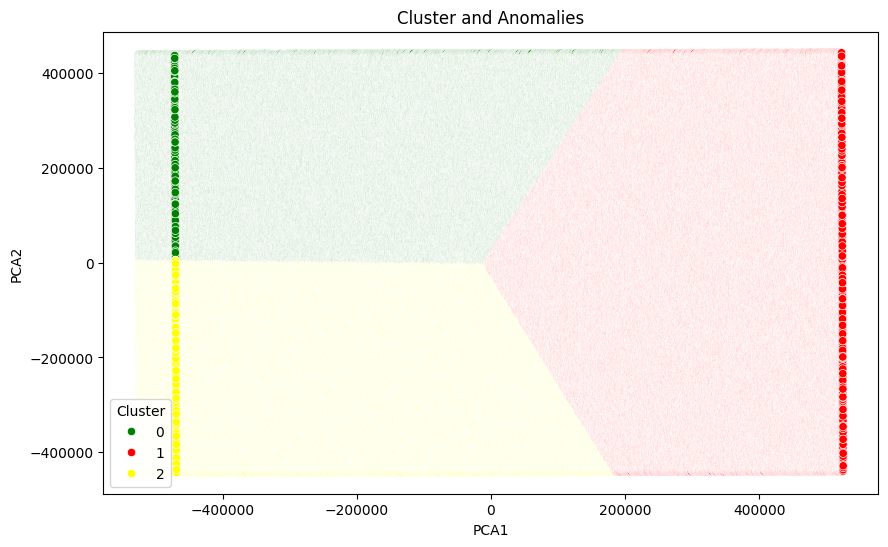

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster',data=data, palette=['green','red','yellow'])
plt.title('Cluster and Anomalies')
plt.legend(title='Cluster')
plt.show()
plt.show()

In [38]:
import pandas as pd

# Assuming 'data' DataFrame is already loaded as shown in the provided code

# Convert 'CustomerDOB' to datetime objects
data['CustomerDOB'] = pd.to_datetime(data['CustomerDOB'])

# Calculate age based on current date
current_date = pd.to_datetime('today')
data['Age'] = (current_date - data['CustomerDOB']).dt.days // 365

# Print the age of each customer
print(data['Age'])

0          30.0
1         -33.0
2          28.0
3         -49.0
4          36.0
           ... 
1048562    34.0
1048563    32.0
1048564    35.0
1048565    46.0
1048566    40.0
Name: Age, Length: 1048567, dtype: float64


In [39]:
#Filter out negative ages
positive_ages = data[data['Age'] > 0]['Age']

# Print the positive ages
positive_ages

,Age
0,30.0
2,28.0
4,36.0
6,33.0
7,43.0
...,...
1048562,34.0
1048563,32.0
1048564,35.0
1048565,46.0
